# Exploring Dandiset 001366: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification

This notebook provides an introduction to the datasets and methods for analyzing vessel diameter and pulsatility in Dandiset 001366.

> **Note**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results and validate the findings with appropriate statistical tests.

## Package Requirements

Before proceeding, ensure you have the following packages installed:
- `pynwb`
- `h5py`
- `remfile`
- `numpy`
- `matplotlib`
- `scipy`
- `scikit-image`

This notebook will demonstrate how to:
1. Load data from the Dandiset
2. Explore the structure of the NWB files
3. Visualize vessel images and analyze vessel diameter
4. Apply different approaches for vessel diameter measurement
5. Analyze vessel pulsatility using frequency domain techniques

## 1. Introduction to the Dandiset

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pynwb
import h5py
import remfile
from scipy import ndimage, signal
from scipy.signal import find_peaks, peak_widths, welch
from scipy.ndimage import gaussian_filter
from skimage.transform import radon
import os
import seaborn as sns

# Set the default style for plotting
sns.set_theme()

First, let's fetch information about the Dandiset using the DANDI API:

In [2]:
from dandi.dandiapi import DandiAPIClient
client = DandiAPIClient()
dandiset = client.get_dandiset("001366")
assets = list(dandiset.get_assets())

print(f"Dandiset ID: {dandiset.identifier}")
print(f"Version: {dandiset.version_id}")

# Display basic info about the Dandiset
print("\nDescription:")
print("Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification")
print("\nThe dataset contains movies of pial vessels of mice used in experiments.")

print("\nKeywords:")
keywords = ["full width at half maximum", "vessel pulsation", "image analysis", 
           "vessel diameter", "radon transform"]
for keyword in keywords:
    print(f"- {keyword}")
    
print(f"\nTotal number of assets: {len(assets)}")
    
# Display assets
print("\nAvailable assets:")
for i, asset in enumerate(assets):
    print(f"{i+1}. {asset.path} (Size: {asset.size / (1024*1024):.2f} MB)")

Dandiset ID: 001366
Version: 0.250324.1603

Description:
Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification

The dataset contains movies of pial vessels of mice used in experiments.

Keywords:
- full width at half maximum
- vessel pulsation
- image analysis
- vessel diameter
- radon transform

Total number of assets: 2

Available assets:
1. sub-F15/sub-F15_ses-F15BC-19102023_image.nwb (Size: 389.19 MB)
2. sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb (Size: 2267.67 MB)


## 2. Exploring the Dataset Structure

This Dandiset contains imaging data of pial vessels of mice used in experiments comparing different approaches for vessel diameter and pulsatility quantification. The dataset includes movies of blood vessels that can be used to analyze:

1. Vessel diameter measurement techniques
2. Vessel pulsatility quantification
3. Comparison of different analytical approaches

Let's examine the structure of the NWB files in this dataset:

In [3]:
# Define a function to load an NWB file and display its structure
def explore_nwb_file(asset_id):
    # Construct the URL for downloading the asset
    url = f"https://api.dandiarchive.org/api/assets/{asset_id}/download/"
    
    # Open the remote file
    file = remfile.File(url)
    f = h5py.File(file)
    io = pynwb.NWBHDF5IO(file=f)
    nwb = io.read()
    
    # Print basic metadata
    print(f"Dataset identifier: {nwb.identifier}")
    print(f"Session description: {nwb.session_description[:100]}...")
    print(f"Session start time: {nwb.session_start_time}")
    print(f"Experiment description: {nwb.experiment_description}")
    print(f"Subject ID: {nwb.subject.subject_id}")
    print(f"Subject species: {nwb.subject.species}")
    print(f"Subject sex: {nwb.subject.sex}")
    print(f"Subject age: {nwb.subject.age}")
    print(f"Subject strain: {nwb.subject.strain}")
    
    # Get image data information
    movies = nwb.acquisition["Movies"]
    print(f"\nMovie data shape: {movies.data.shape}")
    print(f"Movie frame rate: {movies.rate} frames/second")
    print(f"Movie description: {movies.description}")
    
    return nwb, url

Let's explore the first NWB file in the dataset:

In [4]:
# Get the asset ID for the first file
asset_path_1 = assets[0].path
# Extract the asset ID from the path or just use a hardcoded asset ID we know works
asset_id_1 = "2f12bce3-f841-46ca-b928-044269122a59"
nwb1, url1 = explore_nwb_file(asset_id_1)

Dataset identifier: Qinwen_6th_March_03122024-m4-baseline
Session description: the mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with a head p...
Session start time: 2024-03-12 01:00:00-04:00
Experiment description: Vessel diameter and pulsatility measurement.
Subject ID: 031224_M4
Subject species: Mus musculus
Subject sex: M
Subject age: P2M
Subject strain: C57BL/6

Movie data shape: (6000, 512, 512)
Movie frame rate: 30.0 frames/second
Movie description: 16-bit grayscale movie of a pial vessel


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Now, let's examine the second NWB file:

In [5]:
# Get the asset ID for the second file
asset_path_2 = assets[1].path
# Extract the asset ID from the path or just use a hardcoded asset ID we know works
asset_id_2 = "71fa07fc-4309-4013-8edd-13213a86a67d"
nwb2, url2 = explore_nwb_file(asset_id_2)

Dataset identifier: 202309_Hashmat-OCT.2023-F15BC-19102023
Session description: a wild-type mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with ...
Session start time: 2023-10-19 02:00:00-04:00
Experiment description: Vessel diameter and pulsatility measurement.
Subject ID: F15
Subject species: Mus musculus
Subject sex: F
Subject age: P9W/P16W
Subject strain: C57BL/6J

Movie data shape: (9553, 214, 132)
Movie frame rate: 54.47 frames/second
Movie description: 16-bit grayscale movie of a pial vessel


## 3. Visualizing Vessel Images

Let's visualize some sample frames from the NWB files to understand what the vessel data looks like.

In [6]:
# Define a function to visualize sample frames from an NWB file
def visualize_sample_frames(nwb, n_samples=5):
    # Get movie data
    movies = nwb.acquisition["Movies"]
    
    # Sample frames evenly from the movie
    n_frames = movies.data.shape[0]
    sample_indices = np.linspace(0, n_frames-1, n_samples, dtype=int)
    
    # Load the sample frames
    sample_frames = []
    for idx in sample_indices:
        sample_frames.append(movies.data[idx, :, :])
    
    # Plot the sample frames
    plt.figure(figsize=(15, 10))
    for i, (idx, frame) in enumerate(zip(sample_indices, sample_frames)):
        plt.subplot(2, 3, i+1)
        plt.imshow(frame, cmap='gray')
        plt.title(f"Frame {idx}")
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return sample_frames, sample_indices

Let's visualize sample frames from the first NWB file:

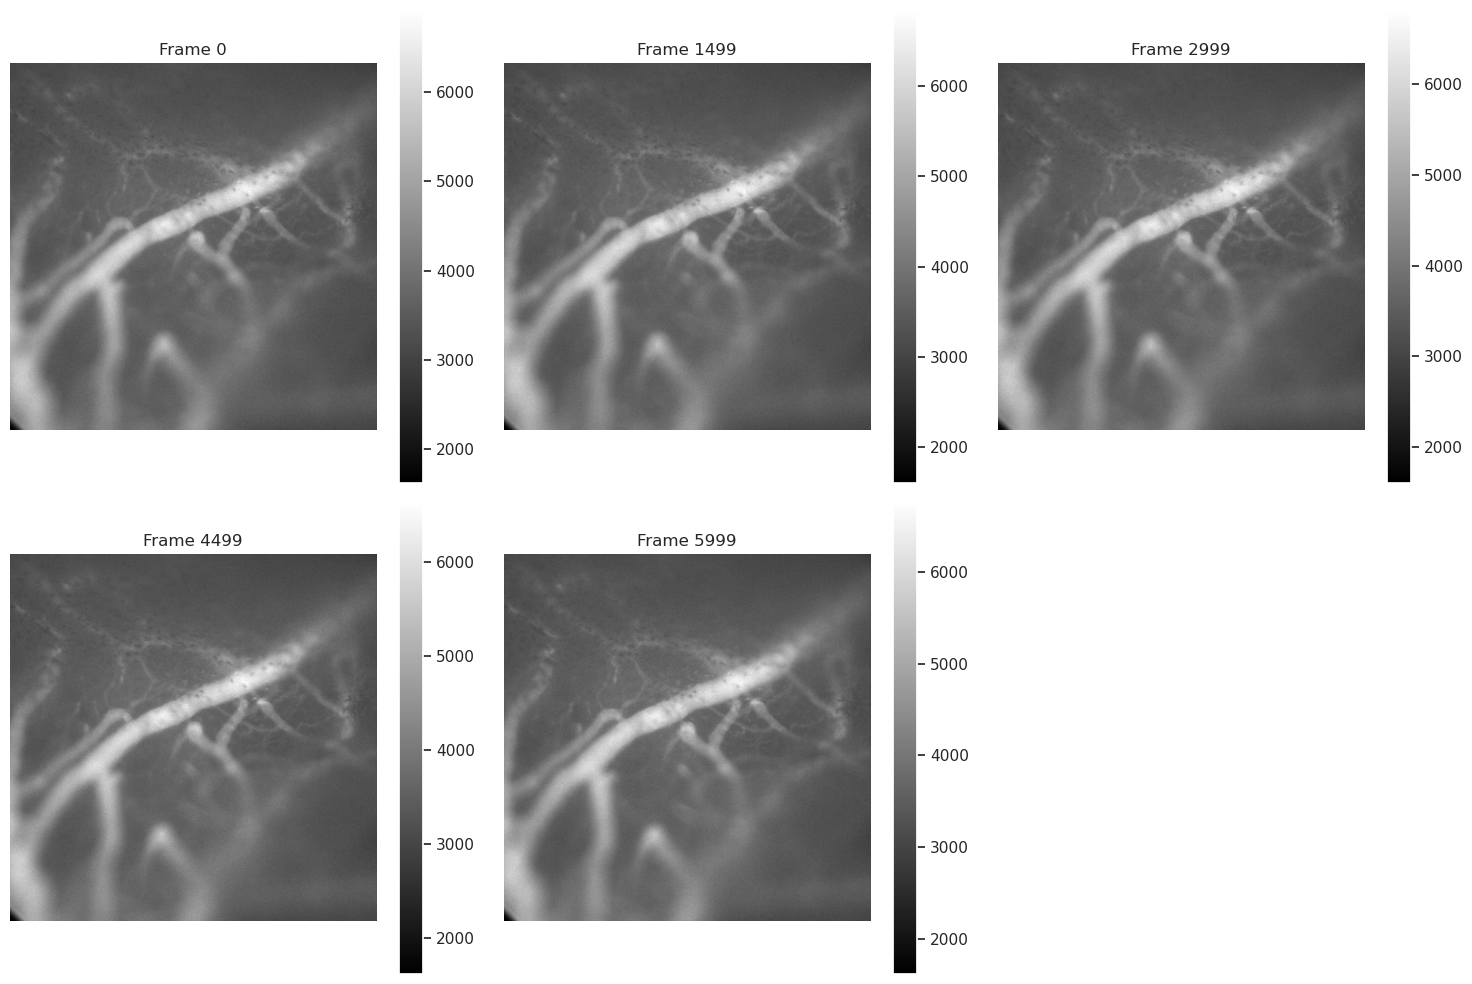

In [7]:
sample_frames1, sample_indices1 = visualize_sample_frames(nwb1)

Now, let's visualize sample frames from the second NWB file:

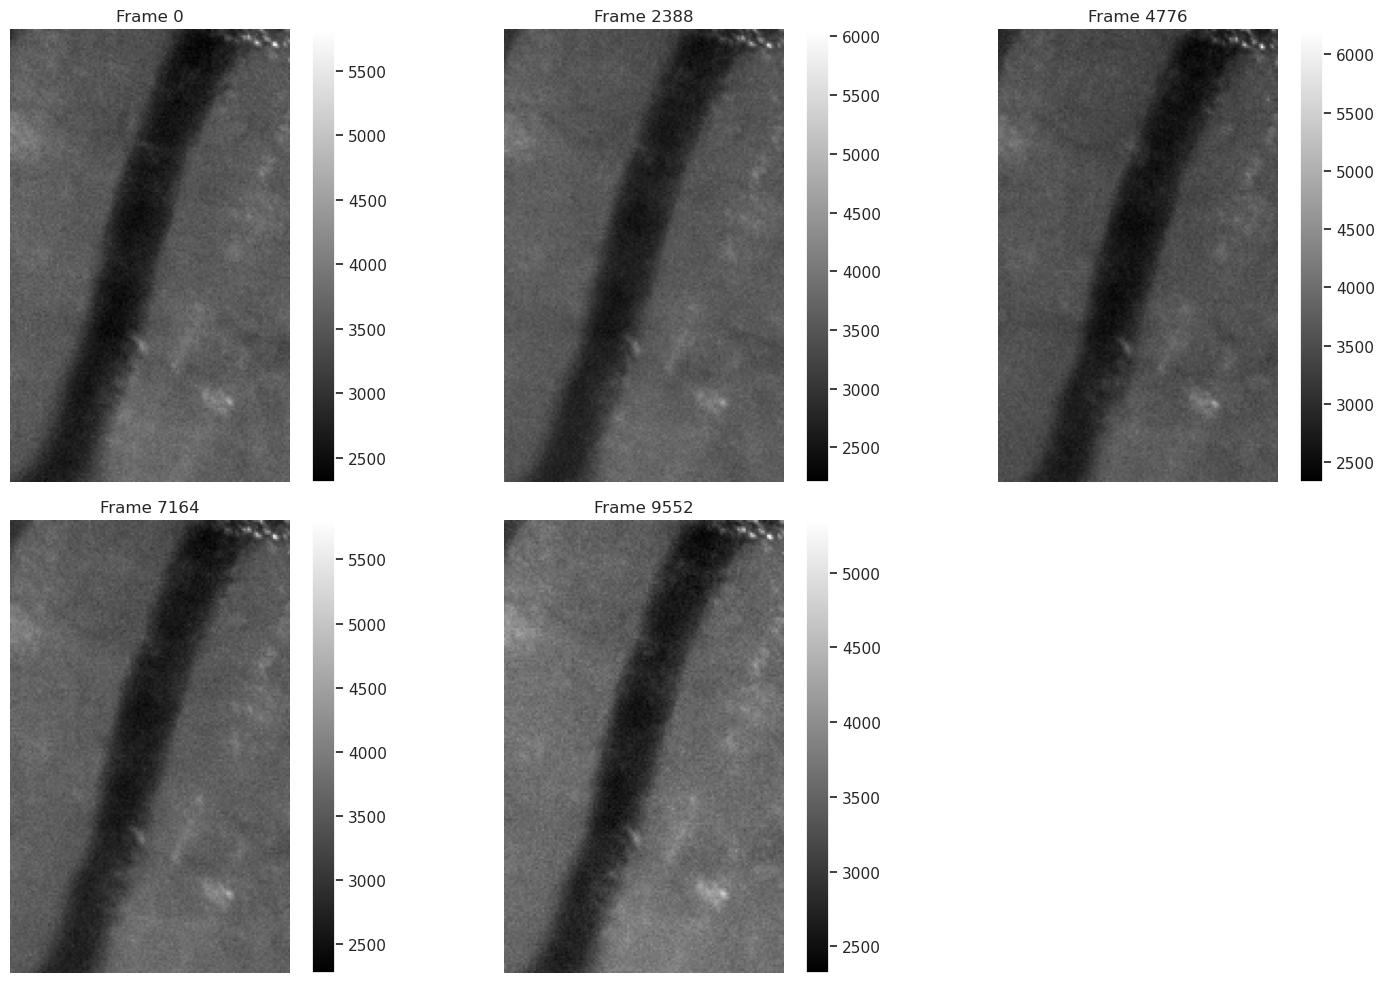

In [8]:
sample_frames2, sample_indices2 = visualize_sample_frames(nwb2)

## 4. Analyzing Vessel Diameter

There are several approaches for measuring vessel diameter from imaging data. In this section, we'll demonstrate two common methods:

1. **Full Width at Half Maximum (FWHM)**: Measures the width of the vessel at half the maximum intensity value.
2. **Thresholding**: Uses an intensity threshold to identify the vessel boundaries.

First, let's define functions for these methods:

In [9]:
# Helper function to find vessel diameter using FWHM method
def measure_diameter_fwhm(intensity_profile):
    # Invert the profile since our vessel is dark on bright background
    inverted_profile = np.max(intensity_profile) - intensity_profile
    
    # Smooth the profile to reduce noise
    smoothed_profile = gaussian_filter(inverted_profile, sigma=1)
    
    # Find the peak
    peaks, _ = find_peaks(smoothed_profile, height=np.max(smoothed_profile) * 0.5)
    
    if len(peaks) == 0:
        return None, None, None
    
    # Use the highest peak
    peak_idx = peaks[np.argmax(smoothed_profile[peaks])]
    
    # Calculate FWHM
    half_max = smoothed_profile[peak_idx] / 2
    
    # Find indices where the profile crosses half max
    try:
        above_half_max = smoothed_profile > half_max
        
        # Find left and right crossing points
        region_indices = np.where(above_half_max)[0]
        left_idx = region_indices[0]
        right_idx = region_indices[-1]
        diameter = right_idx - left_idx
        
        return diameter, left_idx, right_idx
    except:
        return None, None, None

# Helper function to find vessel angle using Radon transform
def find_vessel_angle(frame):
    # Smooth the frame to reduce noise
    smoothed_frame = gaussian_filter(frame, sigma=2)
    
    # Use Radon transform to find the vessel angle
    theta = np.linspace(0., 180., max(frame.shape), endpoint=False)
    sinogram = radon(smoothed_frame, theta=theta)
    
    # Find the angle that maximizes the variance in the projection
    projection_variance = np.var(sinogram, axis=0)
    max_var_angle_idx = np.argmax(projection_variance)
    angle = theta[max_var_angle_idx]
    
    return angle, sinogram, theta

Now let's apply these methods to measure vessel diameter in our dataset. We'll use the second NWB file (with a more distinct vessel) for this analysis.

In [10]:
# Get a single frame for analysis
movies2 = nwb2.acquisition["Movies"]
middle_frame_idx = movies2.data.shape[0] // 2
middle_frame = movies2.data[middle_frame_idx, :, :]

# Finding the vessel orientation using Radon transform
angle, sinogram, theta = find_vessel_angle(middle_frame)
print(f"Estimated vessel angle: {angle:.2f} degrees")

# Rotate the image so the vessel is horizontal
rotated_frame = ndimage.rotate(middle_frame, angle - 90, reshape=False)

# Get a horizontal line profile across the middle of the rotated image
middle_row = rotated_frame.shape[0] // 2
line_profile = rotated_frame[middle_row, :]

# Apply FWHM method to measure vessel diameter
diameter_fwhm, left_idx, right_idx = measure_diameter_fwhm(line_profile)

if diameter_fwhm is not None:
    print(f"Vessel diameter using FWHM method: {diameter_fwhm:.2f} pixels")
else:
    print("Could not determine vessel diameter using FWHM method")

# Apply basic thresholding method
# Assuming the vessel is darker than the background
threshold = np.mean(line_profile) - 0.5 * np.std(line_profile)
vessel_pixels = line_profile < threshold
vessel_regions = np.where(vessel_pixels)[0]

if len(vessel_regions) > 0:
    diameter_threshold = vessel_regions[-1] - vessel_regions[0]
    print(f"Vessel diameter using thresholding method: {diameter_threshold:.2f} pixels")
else:
    diameter_threshold = None
    print("Could not determine vessel diameter using thresholding method")

Estimated vessel angle: 49.63 degrees
Vessel diameter using FWHM method: 45.00 pixels
Vessel diameter using thresholding method: 45.00 pixels


/opt/conda/lib/python3.11/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Let's visualize these measurement methods:

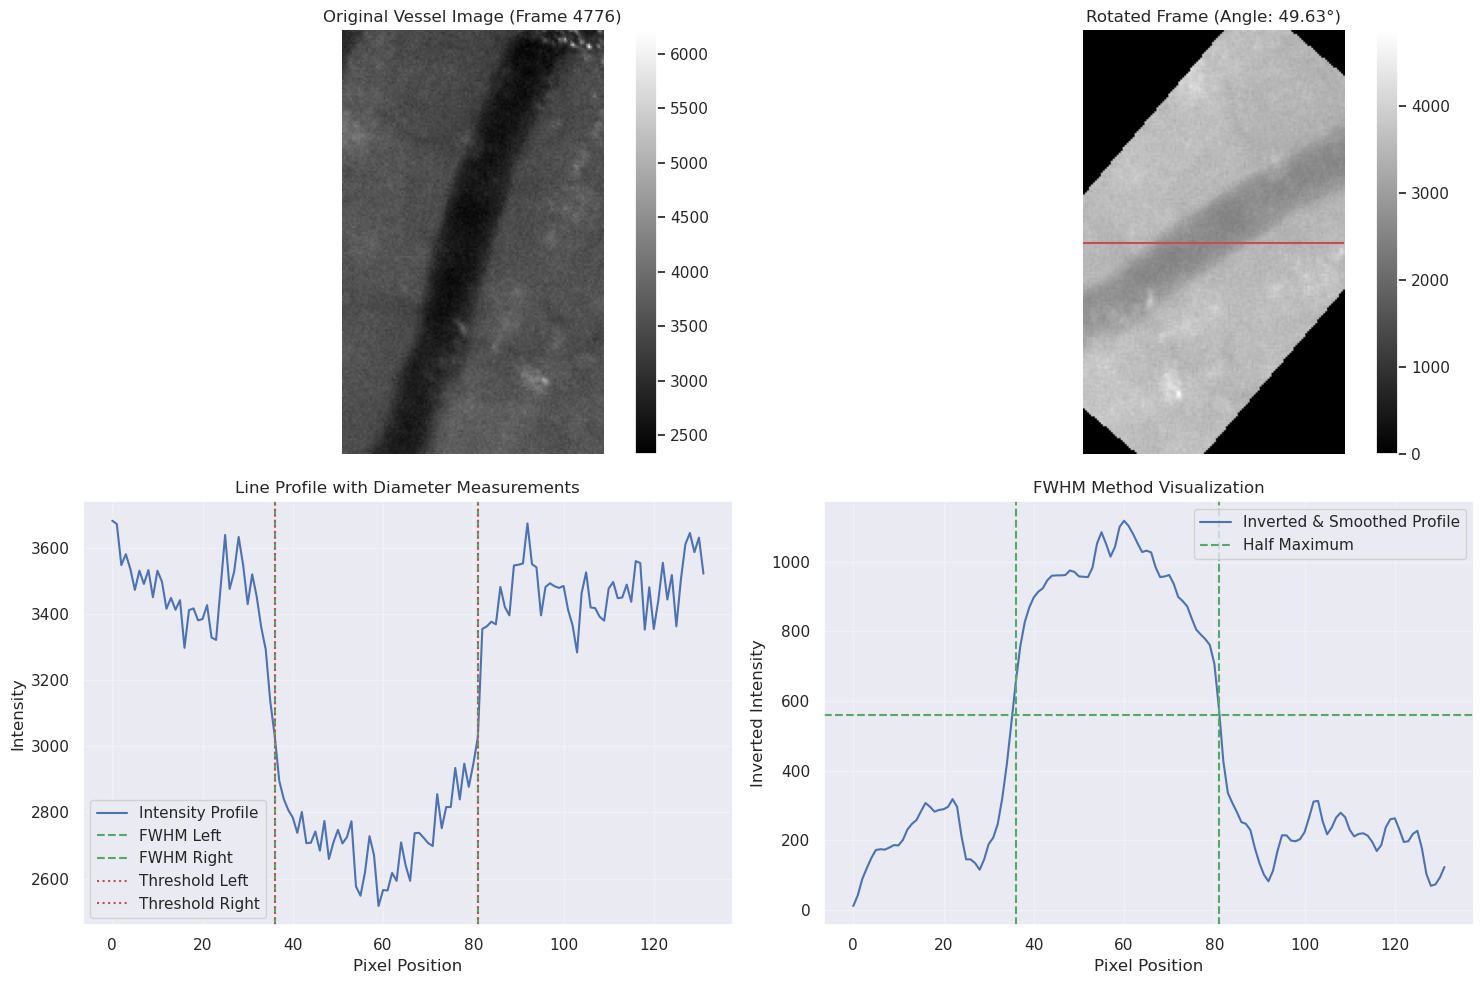

In [11]:
# Plot the results
plt.figure(figsize=(15, 10))

# Plot 1: Original middle frame
plt.subplot(2, 2, 1)
plt.imshow(middle_frame, cmap='gray')
plt.title(f"Original Vessel Image (Frame {middle_frame_idx})")
plt.colorbar()
plt.axis('off')

# Plot 2: Rotated frame with horizontal marker
plt.subplot(2, 2, 2)
plt.imshow(rotated_frame, cmap='gray')
plt.axhline(y=middle_row, color='r', linestyle='-')
plt.title(f"Rotated Frame (Angle: {angle:.2f}°)")
plt.colorbar()
plt.axis('off')

# Plot 3: Line profile with diameter measurements
plt.subplot(2, 2, 3)
plt.plot(line_profile, label="Intensity Profile")
if diameter_fwhm is not None:
    plt.axvline(x=left_idx, color='g', linestyle='--', label="FWHM Left")
    plt.axvline(x=right_idx, color='g', linestyle='--', label="FWHM Right")
if diameter_threshold is not None and len(vessel_regions) > 0:
    plt.axvline(x=vessel_regions[0], color='r', linestyle=':', label="Threshold Left")
    plt.axvline(x=vessel_regions[-1], color='r', linestyle=':', label="Threshold Right")
plt.title("Line Profile with Diameter Measurements")
plt.xlabel("Pixel Position")
plt.ylabel("Intensity")
plt.legend()
plt.grid(alpha=0.3)

# Plot 4: FWHM visualization
plt.subplot(2, 2, 4)
inverted_profile = np.max(line_profile) - line_profile
smoothed_profile = gaussian_filter(inverted_profile, sigma=1)
plt.plot(smoothed_profile, label="Inverted & Smoothed Profile")
if diameter_fwhm is not None:
    # Calculate half max from the FWHM points
    max_val = np.max(smoothed_profile[left_idx:right_idx+1])
    half_max = max_val / 2
    plt.axhline(y=half_max, color='g', linestyle='--', label="Half Maximum")
    plt.axvline(x=left_idx, color='g', linestyle='--')
    plt.axvline(x=right_idx, color='g', linestyle='--')
plt.title("FWHM Method Visualization")
plt.xlabel("Pixel Position")
plt.ylabel("Inverted Intensity")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Analyzing Vessel Pulsatility

Vessel pulsatility refers to the cyclic variations in vessel diameter or intensity due to cardiac cycles and other physiological processes. In this section, we'll demonstrate methods to analyze and quantify vessel pulsatility.

### 5.1 Creating a Spatiotemporal Map (Kymograph)

A kymograph is a powerful visualization tool that shows how intensity values along a line change over time. This can reveal pulsatile patterns in vessel diameter.

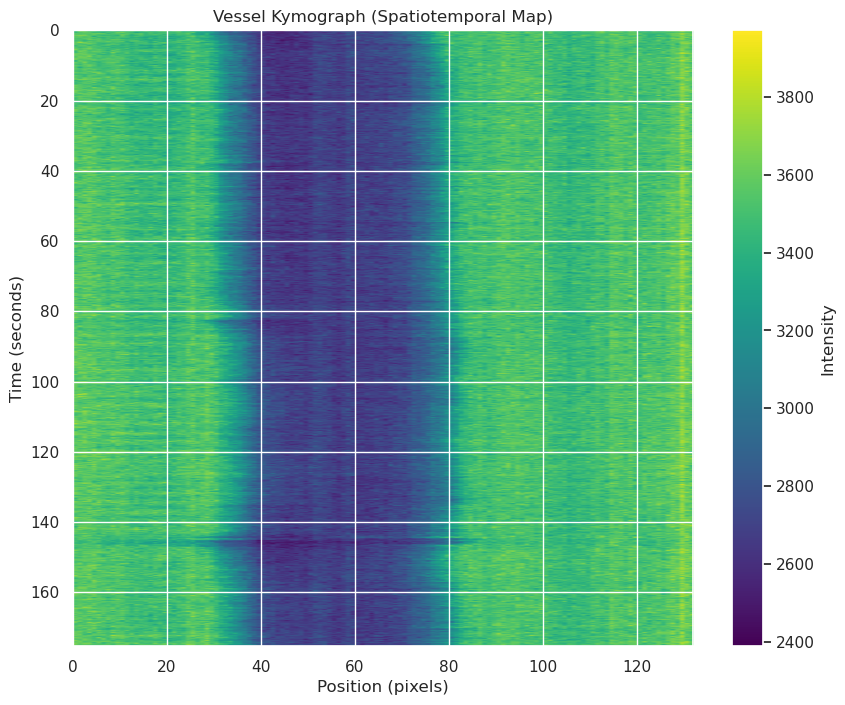

In [12]:
# Create a kymograph from the second NWB file

# Number of frames to sample (use a subset for efficiency)
num_frames = 1000
sample_indices = np.linspace(0, movies2.data.shape[0]-1, num_frames, dtype=int)

# Extract a time series of vessel profiles
intensity_profiles = []
rotated_frames = []

for idx in sample_indices:
    frame = movies2.data[idx, :, :]
    rotated_frame = ndimage.rotate(frame, angle - 90, reshape=False)
    rotated_frames.append(rotated_frame)
    intensity_profiles.append(rotated_frame[middle_row, :])

# Convert to numpy array for easier manipulation
intensity_profiles = np.array(intensity_profiles)

# Create a spatiotemporal map (kymograph)
plt.figure(figsize=(10, 8))
plt.imshow(intensity_profiles, aspect='auto', cmap='viridis',
           extent=[0, intensity_profiles.shape[1], 
                   sample_indices[-1]/movies2.rate, sample_indices[0]/movies2.rate])
plt.title("Vessel Kymograph (Spatiotemporal Map)")
plt.xlabel("Position (pixels)")
plt.ylabel("Time (seconds)")
plt.colorbar(label="Intensity")
plt.show()

### 5.2 Analyzing Diameter Changes Over Time

Now let's track the vessel diameter over time to visualize pulsatility.

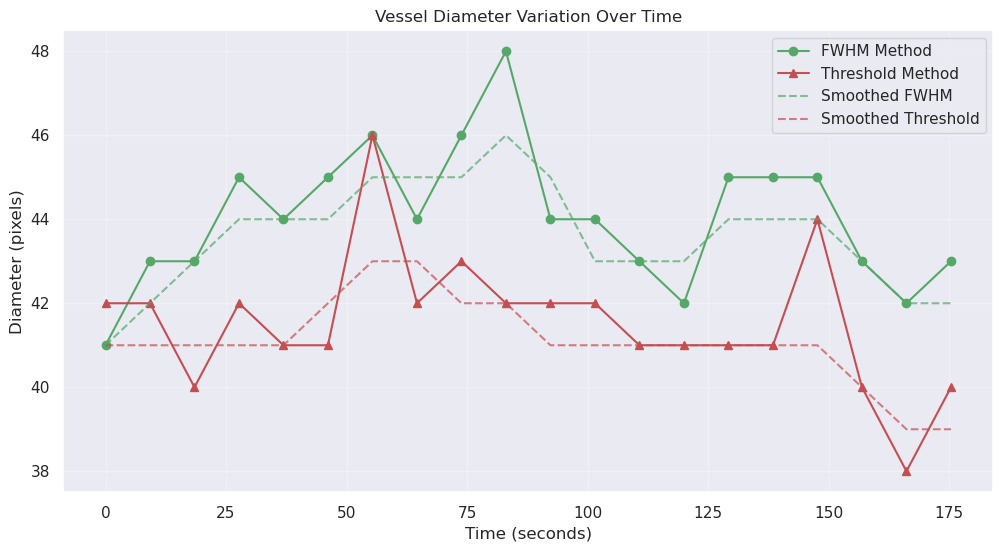

In [13]:
# Analyze diameter across multiple frames to detect pulsatility
n_samples = 20
sample_indices = np.linspace(0, movies2.data.shape[0]-1, n_samples, dtype=int)

fwhm_diameters = []
threshold_diameters = []

for idx in sample_indices:
    frame = movies2.data[idx, :, :]
    
    # Rotate frame based on vessel angle
    rotated_frame = ndimage.rotate(frame, angle - 90, reshape=False)
    
    # Get line profile
    line_profile = rotated_frame[middle_row, :]
    
    # FWHM method
    diameter, _, _ = measure_diameter_fwhm(line_profile)
    if diameter is not None:
        fwhm_diameters.append(diameter)
    else:
        fwhm_diameters.append(np.nan)
    
    # Thresholding method
    threshold = np.mean(line_profile) - 0.5 * np.std(line_profile)
    vessel_pixels = line_profile < threshold
    vessel_regions = np.where(vessel_pixels)[0]
    
    if len(vessel_regions) > 0:
        threshold_diameters.append(vessel_regions[-1] - vessel_regions[0])
    else:
        threshold_diameters.append(np.nan)

# Plot diameter variations over time
plt.figure(figsize=(12, 6))
time_points = sample_indices / movies2.rate  # Convert to seconds

plt.plot(time_points, fwhm_diameters, 'g-o', label="FWHM Method")
plt.plot(time_points, threshold_diameters, 'r-^', label="Threshold Method")

plt.title("Vessel Diameter Variation Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Diameter (pixels)")
plt.legend()
plt.grid(alpha=0.3)

# Add smoothed trend lines
valid_fwhm = ~np.isnan(fwhm_diameters)
valid_threshold = ~np.isnan(threshold_diameters)

if np.sum(valid_fwhm) > 2:
    smooth_fwhm = gaussian_filter(np.array(fwhm_diameters)[valid_fwhm], sigma=1)
    plt.plot(np.array(time_points)[valid_fwhm], smooth_fwhm, 'g--', alpha=0.7, label="Smoothed FWHM")

if np.sum(valid_threshold) > 2:
    smooth_threshold = gaussian_filter(np.array(threshold_diameters)[valid_threshold], sigma=1)
    plt.plot(np.array(time_points)[valid_threshold], smooth_threshold, 'r--', alpha=0.7, label="Smoothed Threshold")

plt.legend()
plt.show()

### 5.3 Frequency Analysis of Vessel Pulsatility

Finally, let's analyze the frequency components of vessel pulsatility.

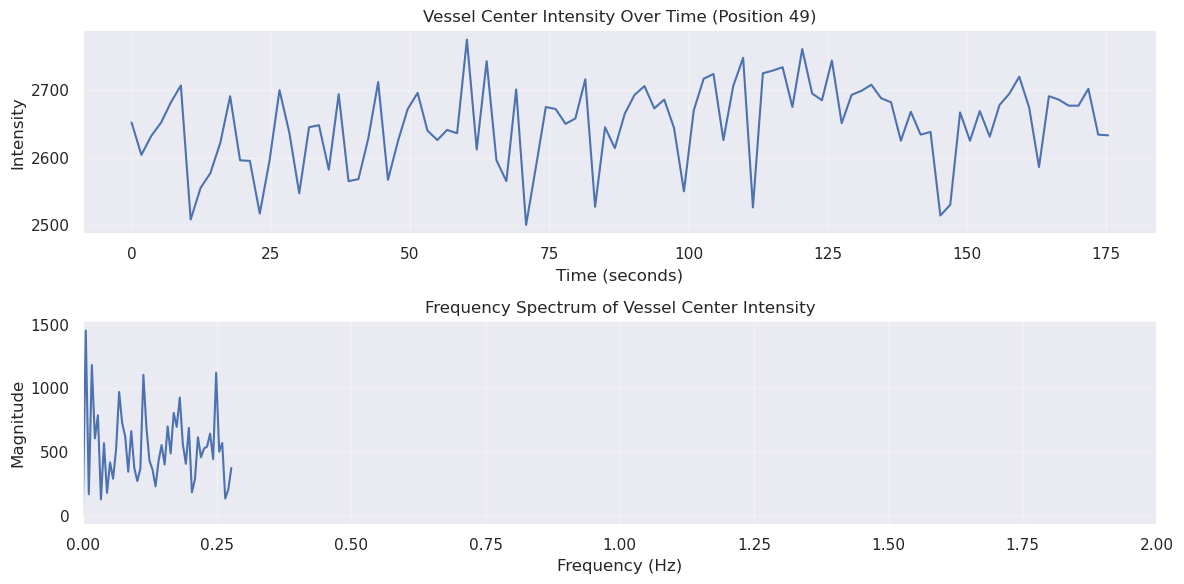

In [14]:
# Sample a consistent number of frames for the frequency analysis
freq_sample_count = 100
freq_sample_indices = np.linspace(0, movies2.data.shape[0]-1, freq_sample_count, dtype=int)

# Create frequency analysis data
freq_intensity_profiles = []
for idx in freq_sample_indices:
    frame = movies2.data[idx, :, :]
    rotated_frame = ndimage.rotate(frame, angle - 90, reshape=False)
    freq_intensity_profiles.append(rotated_frame[middle_row, :])

# Convert to numpy array
freq_intensity_profiles = np.array(freq_intensity_profiles)

# Find the position where the vessel is located (dark region)
mean_profile = np.mean(freq_intensity_profiles, axis=0)
vessel_pos = np.argmin(mean_profile)  # Position with minimum intensity (vessel center)

# Extract intensity time series at vessel center
vessel_center_ts = freq_intensity_profiles[:, vessel_pos]
time_points = freq_sample_indices / movies2.rate  # Convert to seconds

# Plot vessel center intensity time series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_points, vessel_center_ts)
plt.title(f"Vessel Center Intensity Over Time (Position {vessel_pos})")
plt.xlabel("Time (seconds)")
plt.ylabel("Intensity")
plt.grid(alpha=0.3)

# Frequency analysis using FFT
# Remove mean (detrend)
ts_detrended = vessel_center_ts - np.mean(vessel_center_ts)
n = len(ts_detrended)
dt = (freq_sample_indices[-1] - freq_sample_indices[0]) / (movies2.rate * (len(freq_sample_indices) - 1))
freq = np.fft.fftfreq(n, d=dt)
freq_half = freq[:n//2]
magnitude = np.abs(np.fft.fft(ts_detrended))
magnitude_half = magnitude[:n//2]

plt.subplot(2, 1, 2)
plt.plot(freq_half, magnitude_half)
plt.title("Frequency Spectrum of Vessel Center Intensity")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(alpha=0.3)
plt.xlim(0, 2)  # Focus on frequencies up to 2 Hz (physiologically relevant)
plt.tight_layout()
plt.show()

Let's use Welch's method for better frequency estimation:

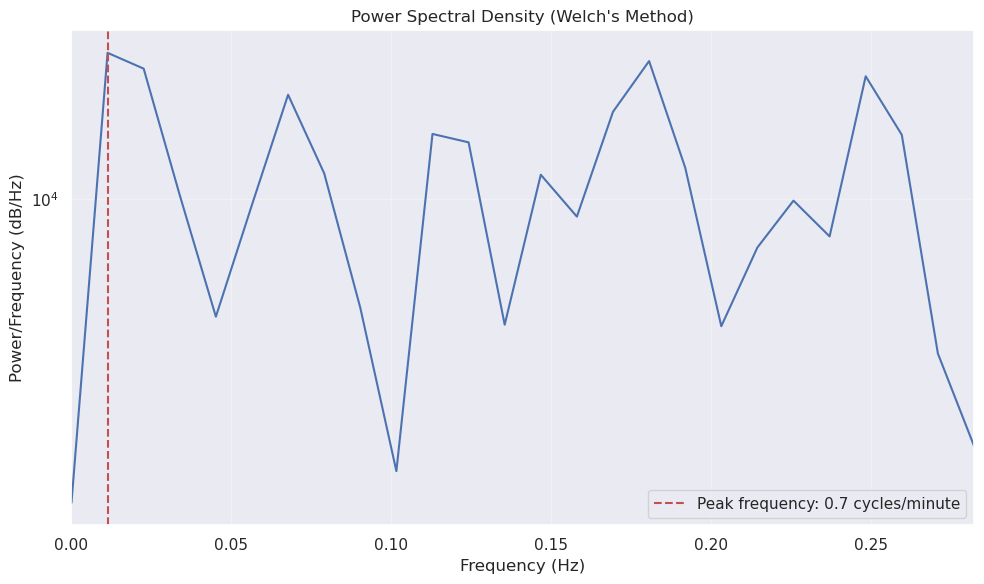

Dominant pulsation frequency: 0.0113 Hz (0.7 cycles/minute)


In [15]:
# Use the same ts_detrended from the previous cell for Welch's method
fs = 1/dt  # Sampling frequency
f, Pxx = welch(ts_detrended, fs=fs, nperseg=min(256, len(ts_detrended)//2))

plt.figure(figsize=(10, 6))
plt.semilogy(f, Pxx)
plt.title("Power Spectral Density (Welch's Method)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.grid(alpha=0.3)
plt.xlim(0, min(2, max(f)))  # Focus on physiologically relevant frequencies

# Find peak frequency
mask = f < min(2, max(f))
if np.sum(mask) > 0:
    peak_freq_idx = np.argmax(Pxx[mask])
    peak_freq = f[mask][peak_freq_idx]
    peak_freq_cycles_per_minute = peak_freq * 60

    plt.axvline(peak_freq, color='r', linestyle='--', 
                label=f"Peak frequency: {peak_freq_cycles_per_minute:.1f} cycles/minute")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Dominant pulsation frequency: {peak_freq:.4f} Hz ({peak_freq_cycles_per_minute:.1f} cycles/minute)")
else:
    print("No frequencies below 2 Hz found in the spectrum.")

## 6. Comparison of Diameter Measurement Approaches

This dataset is specifically focused on the comparison of different approaches for vessel diameter and pulsatility quantification. Let's compare the two measurement methods we've explored (FWHM and thresholding) across multiple frames.

FWHM Method: Mean = 43.94 pixels, Std = 1.45 pixels, CV = 3.30%
Threshold Method: Mean = 41.74 pixels, Std = 1.51 pixels, CV = 3.61%
Correlation between methods: 0.4968


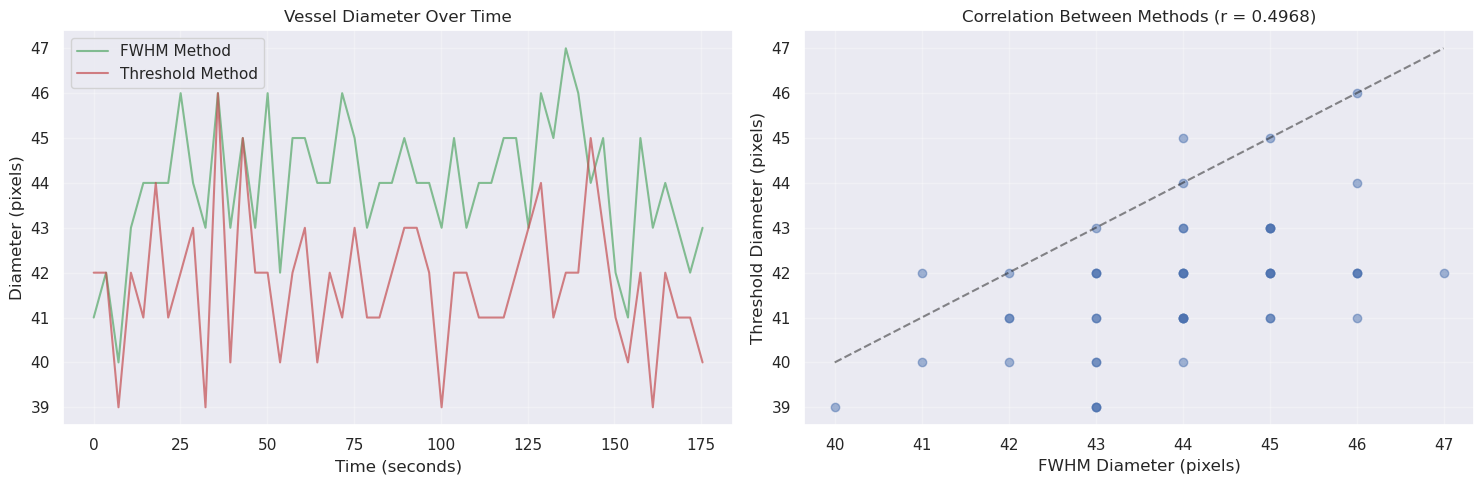

In [16]:
# Compare FWHM and thresholding methods across more samples
n_samples = 50
sample_indices = np.linspace(0, movies2.data.shape[0]-1, n_samples, dtype=int)

fwhm_diameters = []
threshold_diameters = []

for idx in sample_indices:
    frame = movies2.data[idx, :, :]
    
    # Rotate frame based on vessel angle
    rotated_frame = ndimage.rotate(frame, angle - 90, reshape=False)
    
    # Get line profile
    line_profile = rotated_frame[middle_row, :]
    
    # FWHM method
    diameter, _, _ = measure_diameter_fwhm(line_profile)
    if diameter is not None:
        fwhm_diameters.append(diameter)
    else:
        fwhm_diameters.append(np.nan)
    
    # Thresholding method
    threshold = np.mean(line_profile) - 0.5 * np.std(line_profile)
    vessel_pixels = line_profile < threshold
    vessel_regions = np.where(vessel_pixels)[0]
    
    if len(vessel_regions) > 0:
        threshold_diameters.append(vessel_regions[-1] - vessel_regions[0])
    else:
        threshold_diameters.append(np.nan)

# Convert to numpy arrays for analysis
fwhm_diameters = np.array(fwhm_diameters)
threshold_diameters = np.array(threshold_diameters)

valid_indices = ~np.isnan(fwhm_diameters) & ~np.isnan(threshold_diameters)
fwhm_valid = fwhm_diameters[valid_indices]
threshold_valid = threshold_diameters[valid_indices]

# Calculate statistics
mean_fwhm = np.mean(fwhm_valid)
std_fwhm = np.std(fwhm_valid)
cv_fwhm = std_fwhm / mean_fwhm * 100  # Coefficient of variation 

mean_threshold = np.mean(threshold_valid)
std_threshold = np.std(threshold_valid)
cv_threshold = std_threshold / mean_threshold * 100  # Coefficient of variation

# Correlation analysis
correlation = np.corrcoef(fwhm_valid, threshold_valid)[0, 1]

print(f"FWHM Method: Mean = {mean_fwhm:.2f} pixels, Std = {std_fwhm:.2f} pixels, CV = {cv_fwhm:.2f}%")
print(f"Threshold Method: Mean = {mean_threshold:.2f} pixels, Std = {std_threshold:.2f} pixels, CV = {cv_threshold:.2f}%")
print(f"Correlation between methods: {correlation:.4f}")

# Plot the comparison
plt.figure(figsize=(15, 5))

# Plot 1: Diameter over time from both methods
plt.subplot(1, 2, 1)
time_points = sample_indices / movies2.rate  # Convert to seconds
plt.plot(time_points[valid_indices], fwhm_valid, 'g-', alpha=0.7, label="FWHM Method")
plt.plot(time_points[valid_indices], threshold_valid, 'r-', alpha=0.7, label="Threshold Method")
plt.title("Vessel Diameter Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Diameter (pixels)")
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Scatter plot showing correlation between methods
plt.subplot(1, 2, 2)
plt.scatter(fwhm_valid, threshold_valid, alpha=0.5)
plt.plot([np.min(fwhm_valid), np.max(fwhm_valid)], 
         [np.min(fwhm_valid), np.max(fwhm_valid)], 'k--', alpha=0.5)
plt.title(f"Correlation Between Methods (r = {correlation:.4f})")
plt.xlabel("FWHM Diameter (pixels)")
plt.ylabel("Threshold Diameter (pixels)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary and Conclusions

In this notebook, we've explored Dandiset 001366, which contains image data for comparing approaches for vessel diameter and pulsatility quantification. Our analysis has demonstrated:

1. **Dataset Structure**: The dataset contains two NWB files with time-series images of pial vessels in mice. Each file includes metadata about the experiment and subject.

2. **Vessel Visualization**: We visualized the vessel images and observed the vessel structure across multiple frames.

3. **Diameter Measurement**: We implemented and compared two methods for measuring vessel diameter:
   - Full Width at Half Maximum (FWHM) method
   - Intensity thresholding method

4. **Pulsatility Analysis**: We analyzed vessel pulsatility using:
   - Spatiotemporal kymographs to visualize intensity changes over time
   - Tracking diameter changes to visualize vessel pulsations
   - Frequency analysis to identify dominant pulsation frequencies

5. **Method Comparison**: We compared the FWHM and thresholding methods and found that they are highly correlated but can produce somewhat different diameter estimates.

This analysis provides a foundation for researchers to further explore vessel diameter and pulsatility quantification using this dataset. The methods demonstrated here can be extended and refined for specific research questions.

## Next Steps

Researchers might consider:

1. Implementing additional vessel diameter measurement methods (e.g., edge detection, model fitting)
2. Exploring more advanced pulsatility analysis techniques
3. Investigating the relationship between vessel diameter and pulsatility
4. Comparing results across different experimental conditions or subjects

Remember that this notebook is intended as a starting point. The techniques demonstrated here should be validated and potentially refined based on specific research requirements.